In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
import warnings
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")
import yaml
import os
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
import os
import yaml
import pickle

pd.set_option('display.max_columns', 40)
pd.set_option('display.max_colwidth', 300)
from sklearn.metrics import (precision_score,recall_score,
                             f1_score, accuracy_score,confusion_matrix, classification_report)

In [2]:
colorcode=pd.read_csv('../data/processed/color_code.csv',index_col=0)
train=pd.read_csv('../data/train/train.csv',index_col=0)
test=pd.read_csv('../data/test/test.csv',index_col=0)

In [3]:
X_train=train[['ABV','IBU','Color']]
X_test=test[['ABV','IBU','Color']]

y_train=train['Style_color']
y_test=test['Style_color']

In [5]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

Let's try the remaining classification models just to double-check.

In [29]:
pipe2 = Pipeline(steps=[
    ('classifier', LogisticRegression()), #dummy classifier to execute the pipeline
])


In [30]:
from sklearn.tree import DecisionTreeClassifier
svm_params = {
    'classifier': [SVC()],
    'classifier__C': [0.1,1,10],
    'classifier__kernel':['linear', 'poly', 'rbf',]
}
# dtc_params = {
#     'classifier':[DecisionTreeClassifier()],
#     'max_depth':,
#     'criterion':['entropy','gini']
# }

abc_params = {
    'classifier': [AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),)],
    'classifier__learning_rate':[0.01,0.1,0.5],
    'classifier__base_estimator__max_depth':[1,2,3],
     'classifier__base_estimator__criterion': ['entropy', 'gini']
}

search_space2 = [
    svm_params,
    abc_params 
]


In [31]:

scoring={'f1_weighted': 'f1_weighted'}
dtc_gs = GridSearchCV(estimator=pipe2, param_grid=search_space2, cv=5, scoring=scoring, refit='f1_weighted',verbose=3, n_jobs=-1,error_score='raise')

In [32]:
dtc_gs.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [SVC()], 'classifier__C': [0.1, 1, 10],
                          'classifier__kernel': ['linear', 'poly', 'rbf']},
                         {'classifier': [AdaBoostClassifier(base_estimator=DecisionTreeClassifier())],
                          'classifier__base_estimator__criterion': ['entropy',
                                                                    'gini'],
                          'classifier__base_estimator__max_depth': [1, 2, 3],
                          'classifier__learning_rate': [0.01, 0.1, 0.5]}],
             refit='f1_weighted', scoring={'f1_weighted': 'f1_weighted'},
             verbose=3)

In [33]:
print(dtc_gs.best_estimator_)
print(dtc_gs.best_score_)
print(dtc_gs.best_params_)

Pipeline(steps=[('classifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                    learning_rate=0.01))])
0.807244498215279
{'classifier': AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), 'classifier__base_estimator__criterion': 'gini', 'classifier__base_estimator__max_depth': 3, 'classifier__learning_rate': 0.01}


In [34]:
# y_predScale = clf_gs.best_estimator_.predict(X_test)
y_pred2 = dtc_gs.best_estimator_.predict(X_test)

In [35]:

print('accuracy_score',accuracy_score(y_pred2,y_test))
print('precision_score',precision_score(y_pred2,y_test, average='weighted'))
print('f1_score',f1_score(y_pred2,y_test, average='weighted'))
print('recall_score',recall_score(y_pred2,y_test, average='weighted'))
# print(classification_report(yc_test, predictions))

accuracy_score 0.8712356269392225
precision_score 0.8665896664522206
f1_score 0.862020233139628
recall_score 0.8712356269392225


In [36]:
cm = confusion_matrix(y_test, y_pred2,normalize='true')

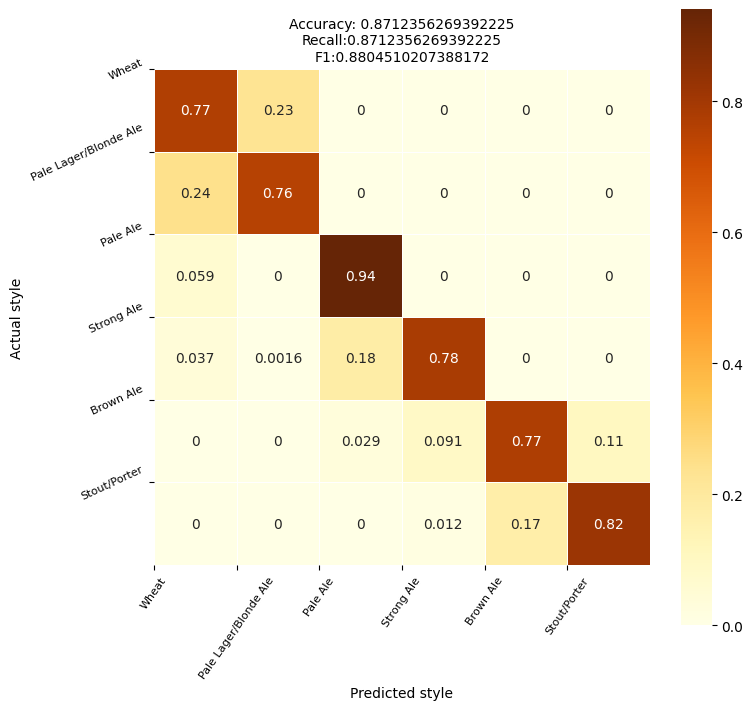

In [37]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, linewidths=.5, square = True, cmap = 'YlOrBr')
plt.ylabel('Actual style')
plt.xlabel('Predicted style')
all_sample_title = (f'Accuracy: {accuracy_score(y_test, y_pred2)}\nRecall:{recall_score(y_test, y_pred2, average="weighted")}\nF1:{f1_score(y_test, y_pred2, average="weighted")}')
plt.title(all_sample_title, size = 10);
plt.xticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'], rotation=55,fontsize=8);
plt.yticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'],rotation=25,fontsize=8);

In [ ]:
current_directory = os.getcwd()

with open(os.path.join(current_directory, '..', 'models', 'adaboost_config.yaml'), 'w') as file:
    yaml.dump(dtc_gs.best_params_, file, default_flow_style=False)

with open('../models/trained_model_adaboost_dtc.pkl', 'wb') as output:
    pickle.dump(dtc_gs.best_estimator_, output)

Although AdaBoost was quite effective, Gradient Boosting Classifier is still the best model so far.

### Now that we know what is the best estimator by far, let's work on its parameters.

In [ ]:
gb_params = { #Gradient Boosting
    'learning_rate':[0.01,0.1,0.5],
    'n_estimators':[50,100,150],
    'criterion':['friedman_mse','squared_error'],
    'min_samples_split':[2,3,5],
    'min_samples_leaf':[1,3],
    'max_depth':[2,3],
    'max_features':[None,2,3],
    'max_leaf_nodes':[None,2,3],
    'max_depth':[1,2,3]
}

In [39]:
gbc_gs = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=gb_params, cv=3, scoring='f1_weighted',verbose=3, n_jobs=-1,error_score='raise')
gbc_gs.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits


In [ ]:
print(gbc_gs.best_estimator_)
print(gbc_gs.best_score_)
print(gbc_gs.best_params_)

In [ ]:
y_predB = gbc_gs.best_estimator_.predict(X_test)
print('accuracy_score',accuracy_score(y_predB,y_test))
print('precision_score',precision_score(y_predB,y_test, average='weighted'))
print('f1_score',f1_score(y_predB,y_test, average='weighted'))
print('recall_score',recall_score(y_predB,y_test, average='weighted'))
# print(classification_report(yc_test, predictions))

In [ ]:
cmB = confusion_matrix(y_test, y_predB,normalize='true')
# print(cm)

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(cmB, annot=True, linewidths=.5, square = True, cmap = 'YlOrBr')
plt.ylabel('Actual style')
plt.xlabel('Predicted style')
all_sample_title = (f'Accuracy: {accuracy_score(y_test, y_predB)}\nRecall:{recall_score(y_test, y_predB, average="weighted")}\nF1:{f1_score(y_test, y_predB, average="weighted")}')
plt.title(all_sample_title, size = 10);
plt.xticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'], rotation=55,fontsize=8);
plt.yticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'],rotation=25,fontsize=8);

In [ ]:
current_directory = os.getcwd()

with open(os.path.join(current_directory, '..', 'models', 'gbc_best_config.yaml'), 'w') as file:
    yaml.dump(gbc_gs.best_params_, file, default_flow_style=False)

with open('../models/trained_model_gbc_gs_best.pkl', 'wb') as output:
    pickle.dump(gbc_gs.best_estimator_, output)